## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net



net = Net()
print(net)
if train_on_gpu:
    net.cuda()

CUDA is available!  Training on GPU ...
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4)
  (fc1): Linear(in_features=173056, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

##### Additional, 

I have build a function to rotate the image and the keypoints to perform data augmentation, as proposed. I have created a function to rotate the image and the keypoint randomly given a int num -> [-90,90]

I have writen the extra cell below to test the whole compose process.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


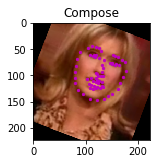

In [3]:
from data_load import FacialKeypointsDataset    
from data_load import Rescale, RandomCrop, Normalize, ToTensor, RandomRotation
from torchvision import transforms, utils


def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

composed = transforms.Compose([Rescale(250),
                               RandomCrop(224),
                               RandomRotation(30)
                              ])

transformed_dataset2 = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                            )
# apply the transforms to a sample image
test_num = 500
sample = transformed_dataset2[test_num]

fig = plt.figure()
for i, tx in enumerate([composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from data_load import FacialKeypointsDataset    

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor, RandomRotation


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomRotation(90),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        if train_on_gpu:
            images, key_pts = images.cuda(), key_pts.cuda()
            images = images.type(torch.cuda.FloatTensor)
        else: 
            images = images.type(torch.FloatTensor)
        
        # convert images to FloatTensors
        
        

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

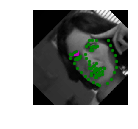

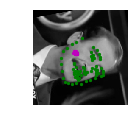

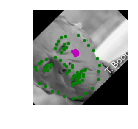

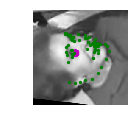

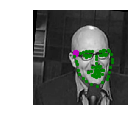

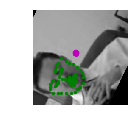

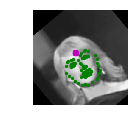

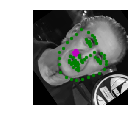

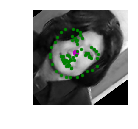

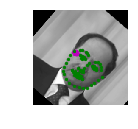

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy() if train_on_gpu else image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy() if train_on_gpu else predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts.cpu() if train_on_gpu else ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            if train_on_gpu:
                images, key_pts = images.cuda(), key_pts.cuda()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
from workspace_utils import active_session

n_epochs = 80 # start small, and increase when you've decided on your model structure and hyperparams
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.3735881248116493
Epoch: 1, Batch: 20, Avg. Loss: 0.00536388686299324
Epoch: 1, Batch: 30, Avg. Loss: 0.0043395026326179505
Epoch: 1, Batch: 40, Avg. Loss: 0.0039053312540054323
Epoch: 1, Batch: 50, Avg. Loss: 0.003813058465719223
Epoch: 1, Batch: 60, Avg. Loss: 0.003940525293350219
Epoch: 1, Batch: 70, Avg. Loss: 0.0039244193732738495
Epoch: 1, Batch: 80, Avg. Loss: 0.0038433513045310974
Epoch: 1, Batch: 90, Avg. Loss: 0.0036466255486011503
Epoch: 1, Batch: 100, Avg. Loss: 0.003743731528520584


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.003897414565086365
Epoch: 2, Batch: 20, Avg. Loss: 0.004054831176996231
Epoch: 2, Batch: 30, Avg. Loss: 0.0036037879288196564
Epoch: 2, Batch: 40, Avg. Loss: 0.003746836006641388
Epoch: 2, Batch: 50, Avg. Loss: 0.003755015581846237
Epoch: 2, Batch: 60, Avg. Loss: 0.003864674121141434
Epoch: 2, Batch: 70, Avg. Loss: 0.004043487936258316
Epoch: 2, Batch: 80, Avg. Loss: 0.0038355876803398132
Epoch: 2, Batch: 90, Avg. Loss: 0.003675534427165985
Epoch: 2, Batch: 100, Avg. Loss: 0.0037149693667888643


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.003943638473749161
Epoch: 3, Batch: 20, Avg. Loss: 0.003401961028575897
Epoch: 3, Batch: 30, Avg. Loss: 0.004222985327243805
Epoch: 3, Batch: 40, Avg. Loss: 0.0038372986912727355
Epoch: 3, Batch: 50, Avg. Loss: 0.004007862702012062
Epoch: 3, Batch: 60, Avg. Loss: 0.003540732651948929
Epoch: 3, Batch: 70, Avg. Loss: 0.0036450276374816893
Epoch: 3, Batch: 80, Avg. Loss: 0.0037947705686092376
Epoch: 3, Batch: 90, Avg. Loss: 0.003657223641872406
Epoch: 3, Batch: 100, Avg. Loss: 0.0038084931671619414


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.0034618050158023834
Epoch: 4, Batch: 20, Avg. Loss: 0.0034886177480220795
Epoch: 4, Batch: 30, Avg. Loss: 0.003775575548410416
Epoch: 4, Batch: 40, Avg. Loss: 0.0032561451196670534
Epoch: 4, Batch: 50, Avg. Loss: 0.0035801269114017487
Epoch: 4, Batch: 60, Avg. Loss: 0.003705320119857788
Epoch: 4, Batch: 70, Avg. Loss: 0.003328495740890503
Epoch: 4, Batch: 80, Avg. Loss: 0.0033015224039554597
Epoch: 4, Batch: 90, Avg. Loss: 0.0032175431549549102
Epoch: 4, Batch: 100, Avg. Loss: 0.003068155884742737


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.0031452154219150544
Epoch: 5, Batch: 20, Avg. Loss: 0.0036052490770816805
Epoch: 5, Batch: 30, Avg. Loss: 0.003145202189683914
Epoch: 5, Batch: 40, Avg. Loss: 0.0028255521059036256
Epoch: 5, Batch: 50, Avg. Loss: 0.0030478134155273438
Epoch: 5, Batch: 60, Avg. Loss: 0.0027497465163469313
Epoch: 5, Batch: 70, Avg. Loss: 0.0028172597587108614
Epoch: 5, Batch: 80, Avg. Loss: 0.0027647647112607958
Epoch: 5, Batch: 90, Avg. Loss: 0.0029127042889595034
Epoch: 5, Batch: 100, Avg. Loss: 0.0029049286842346192


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.0025067228376865385
Epoch: 6, Batch: 20, Avg. Loss: 0.002847719639539719
Epoch: 6, Batch: 30, Avg. Loss: 0.0026758922040462495
Epoch: 6, Batch: 40, Avg. Loss: 0.002613321766257286
Epoch: 6, Batch: 50, Avg. Loss: 0.0028424434512853624
Epoch: 6, Batch: 60, Avg. Loss: 0.0027082011848688125
Epoch: 6, Batch: 70, Avg. Loss: 0.0026204417645931243
Epoch: 6, Batch: 80, Avg. Loss: 0.0028417056649923324
Epoch: 6, Batch: 90, Avg. Loss: 0.002430662527680397
Epoch: 6, Batch: 100, Avg. Loss: 0.0025779223889112472


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.002952085256576538
Epoch: 7, Batch: 20, Avg. Loss: 0.002202021762728691
Epoch: 7, Batch: 30, Avg. Loss: 0.002949138045310974
Epoch: 7, Batch: 40, Avg. Loss: 0.0028434233218431475
Epoch: 7, Batch: 50, Avg. Loss: 0.002652069300413132
Epoch: 7, Batch: 60, Avg. Loss: 0.0026938458532094955
Epoch: 7, Batch: 70, Avg. Loss: 0.0025846526324748995
Epoch: 7, Batch: 80, Avg. Loss: 0.0025223186314105987
Epoch: 7, Batch: 90, Avg. Loss: 0.0029415892511606215
Epoch: 7, Batch: 100, Avg. Loss: 0.002637414187192917


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.0025224777162075043
Epoch: 8, Batch: 20, Avg. Loss: 0.0024362189024686814
Epoch: 8, Batch: 30, Avg. Loss: 0.0025372809916734697
Epoch: 8, Batch: 40, Avg. Loss: 0.0024022143483161925
Epoch: 8, Batch: 50, Avg. Loss: 0.002576466977596283
Epoch: 8, Batch: 60, Avg. Loss: 0.0023554626405239104
Epoch: 8, Batch: 70, Avg. Loss: 0.0026054379642009733
Epoch: 8, Batch: 80, Avg. Loss: 0.0027915159910917283
Epoch: 8, Batch: 90, Avg. Loss: 0.002351701095700264
Epoch: 8, Batch: 100, Avg. Loss: 0.0025860666185617445


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.002626525282859802
Epoch: 9, Batch: 20, Avg. Loss: 0.0025169135332107546
Epoch: 9, Batch: 30, Avg. Loss: 0.0024669210463762283
Epoch: 9, Batch: 40, Avg. Loss: 0.002169191002845764
Epoch: 9, Batch: 50, Avg. Loss: 0.0025772949159145356
Epoch: 9, Batch: 60, Avg. Loss: 0.0023146099895238878
Epoch: 9, Batch: 70, Avg. Loss: 0.002473295599222183
Epoch: 9, Batch: 80, Avg. Loss: 0.0024461681097745895
Epoch: 9, Batch: 90, Avg. Loss: 0.0023329999446868896
Epoch: 9, Batch: 100, Avg. Loss: 0.002158745840191841


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.002694535031914711
Epoch: 10, Batch: 20, Avg. Loss: 0.002543848916888237
Epoch: 10, Batch: 30, Avg. Loss: 0.002487397715449333
Epoch: 10, Batch: 40, Avg. Loss: 0.002429651468992233
Epoch: 10, Batch: 50, Avg. Loss: 0.0021533458083868025
Epoch: 10, Batch: 60, Avg. Loss: 0.002236563950777054
Epoch: 10, Batch: 70, Avg. Loss: 0.0022340897470712663
Epoch: 10, Batch: 80, Avg. Loss: 0.002208896443247795
Epoch: 10, Batch: 90, Avg. Loss: 0.002245757609605789
Epoch: 10, Batch: 100, Avg. Loss: 0.0021895140260457992


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.0022109700143337248
Epoch: 11, Batch: 20, Avg. Loss: 0.0020586877465248107
Epoch: 11, Batch: 30, Avg. Loss: 0.0020599377900362014
Epoch: 11, Batch: 40, Avg. Loss: 0.0022548514902591705
Epoch: 11, Batch: 50, Avg. Loss: 0.0026325327754020693
Epoch: 11, Batch: 60, Avg. Loss: 0.0021963369697332383
Epoch: 11, Batch: 70, Avg. Loss: 0.0020970776230096817
Epoch: 11, Batch: 80, Avg. Loss: 0.002411230161786079
Epoch: 11, Batch: 90, Avg. Loss: 0.0022700646072626113
Epoch: 11, Batch: 100, Avg. Loss: 0.0019805459082126615


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.0022908297628164292
Epoch: 12, Batch: 20, Avg. Loss: 0.002103402569890022
Epoch: 12, Batch: 30, Avg. Loss: 0.002212870270013809
Epoch: 12, Batch: 40, Avg. Loss: 0.002070097476243973
Epoch: 12, Batch: 50, Avg. Loss: 0.0025907891988754274
Epoch: 12, Batch: 60, Avg. Loss: 0.002216799944639206
Epoch: 12, Batch: 70, Avg. Loss: 0.0023402422666549683
Epoch: 12, Batch: 80, Avg. Loss: 0.0021651208847761156
Epoch: 12, Batch: 90, Avg. Loss: 0.0021298916935920714
Epoch: 12, Batch: 100, Avg. Loss: 0.002218116208910942


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.002291151836514473
Epoch: 13, Batch: 20, Avg. Loss: 0.0021475788503885268
Epoch: 13, Batch: 30, Avg. Loss: 0.002024466097354889
Epoch: 13, Batch: 40, Avg. Loss: 0.002214476123452187
Epoch: 13, Batch: 50, Avg. Loss: 0.0023073080629110337
Epoch: 13, Batch: 60, Avg. Loss: 0.002169671580195427
Epoch: 13, Batch: 70, Avg. Loss: 0.0021257983446121217
Epoch: 13, Batch: 80, Avg. Loss: 0.002088436335325241
Epoch: 13, Batch: 90, Avg. Loss: 0.002129826262593269
Epoch: 13, Batch: 100, Avg. Loss: 0.002591760665178299


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.002073319286108017
Epoch: 14, Batch: 20, Avg. Loss: 0.002185139000415802
Epoch: 14, Batch: 30, Avg. Loss: 0.002163227155804634
Epoch: 14, Batch: 40, Avg. Loss: 0.0025504335910081864
Epoch: 14, Batch: 50, Avg. Loss: 0.0021952053159475324
Epoch: 14, Batch: 60, Avg. Loss: 0.0019028750509023666
Epoch: 14, Batch: 70, Avg. Loss: 0.0023151306062936783
Epoch: 14, Batch: 80, Avg. Loss: 0.002017352893948555
Epoch: 14, Batch: 90, Avg. Loss: 0.002136518508195877
Epoch: 14, Batch: 100, Avg. Loss: 0.0018891418427228928


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.001985398292541504
Epoch: 15, Batch: 20, Avg. Loss: 0.002170480191707611
Epoch: 15, Batch: 30, Avg. Loss: 0.0021744756251573564
Epoch: 15, Batch: 40, Avg. Loss: 0.002225579097867012
Epoch: 15, Batch: 50, Avg. Loss: 0.0021681334674358366
Epoch: 15, Batch: 60, Avg. Loss: 0.001866821825504303
Epoch: 15, Batch: 70, Avg. Loss: 0.0022943110316991804
Epoch: 15, Batch: 80, Avg. Loss: 0.0019552657455205917
Epoch: 15, Batch: 90, Avg. Loss: 0.0020118500888347624
Epoch: 15, Batch: 100, Avg. Loss: 0.0020796917229890825


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.0021319645866751673
Epoch: 16, Batch: 20, Avg. Loss: 0.0019924004524946213
Epoch: 16, Batch: 30, Avg. Loss: 0.001955035895109177
Epoch: 16, Batch: 40, Avg. Loss: 0.002082598924636841
Epoch: 16, Batch: 50, Avg. Loss: 0.002000341460108757
Epoch: 16, Batch: 60, Avg. Loss: 0.0021112826317548753
Epoch: 16, Batch: 70, Avg. Loss: 0.0019280653595924377
Epoch: 16, Batch: 80, Avg. Loss: 0.002117240145802498
Epoch: 16, Batch: 90, Avg. Loss: 0.001873455435037613
Epoch: 16, Batch: 100, Avg. Loss: 0.002131744384765625


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.0018942561149597169
Epoch: 17, Batch: 20, Avg. Loss: 0.0020591951161623
Epoch: 17, Batch: 30, Avg. Loss: 0.002980251252651215
Epoch: 17, Batch: 40, Avg. Loss: 0.00225853331387043
Epoch: 17, Batch: 50, Avg. Loss: 0.0019897143095731736
Epoch: 17, Batch: 60, Avg. Loss: 0.002087445393204689
Epoch: 17, Batch: 70, Avg. Loss: 0.002056093335151672
Epoch: 17, Batch: 80, Avg. Loss: 0.00199633814394474
Epoch: 17, Batch: 90, Avg. Loss: 0.0018886574804782867
Epoch: 17, Batch: 100, Avg. Loss: 0.0019496083706617355


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.0018048187792301178
Epoch: 18, Batch: 20, Avg. Loss: 0.001953681394457817
Epoch: 18, Batch: 30, Avg. Loss: 0.002239015430212021
Epoch: 18, Batch: 40, Avg. Loss: 0.0019068826735019683
Epoch: 18, Batch: 50, Avg. Loss: 0.0020399458557367324
Epoch: 18, Batch: 60, Avg. Loss: 0.0019053558707237243
Epoch: 18, Batch: 70, Avg. Loss: 0.001854424923658371
Epoch: 18, Batch: 80, Avg. Loss: 0.002045050263404846
Epoch: 18, Batch: 90, Avg. Loss: 0.0017193229049444199
Epoch: 18, Batch: 100, Avg. Loss: 0.0020956283807754515


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.0017788508012890815
Epoch: 19, Batch: 20, Avg. Loss: 0.0018638685643672943
Epoch: 19, Batch: 30, Avg. Loss: 0.0018849443644285203
Epoch: 19, Batch: 40, Avg. Loss: 0.0017885758131742477
Epoch: 19, Batch: 50, Avg. Loss: 0.0019511961936950683
Epoch: 19, Batch: 60, Avg. Loss: 0.0018303591161966323
Epoch: 19, Batch: 70, Avg. Loss: 0.0020093166679143906
Epoch: 19, Batch: 80, Avg. Loss: 0.0019786281436681746
Epoch: 19, Batch: 90, Avg. Loss: 0.0020434237271547318
Epoch: 19, Batch: 100, Avg. Loss: 0.0019575526118278505


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.0018009308725595475
Epoch: 20, Batch: 20, Avg. Loss: 0.0018536038547754287
Epoch: 20, Batch: 30, Avg. Loss: 0.0020670571699738503
Epoch: 20, Batch: 40, Avg. Loss: 0.0018933912366628648
Epoch: 20, Batch: 50, Avg. Loss: 0.0018085498511791229
Epoch: 20, Batch: 60, Avg. Loss: 0.0017255237102508545
Epoch: 20, Batch: 70, Avg. Loss: 0.0024660144746303557
Epoch: 20, Batch: 80, Avg. Loss: 0.0019551339745521546
Epoch: 20, Batch: 90, Avg. Loss: 0.0019210530519485473
Epoch: 20, Batch: 100, Avg. Loss: 0.001993253543972969


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.001898748129606247
Epoch: 21, Batch: 20, Avg. Loss: 0.0019221950769424438
Epoch: 21, Batch: 30, Avg. Loss: 0.0019746031165122986
Epoch: 21, Batch: 40, Avg. Loss: 0.0019417384266853333
Epoch: 21, Batch: 50, Avg. Loss: 0.0019472970515489578
Epoch: 21, Batch: 60, Avg. Loss: 0.0015752657502889633
Epoch: 21, Batch: 70, Avg. Loss: 0.0018652236461639403
Epoch: 21, Batch: 80, Avg. Loss: 0.0017129859924316405
Epoch: 21, Batch: 90, Avg. Loss: 0.0018490545749664307
Epoch: 21, Batch: 100, Avg. Loss: 0.0016199606135487556


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.001854817807674408
Epoch: 22, Batch: 20, Avg. Loss: 0.0017932431101799011
Epoch: 22, Batch: 30, Avg. Loss: 0.0017216714695096017
Epoch: 22, Batch: 40, Avg. Loss: 0.0016690225750207901
Epoch: 22, Batch: 50, Avg. Loss: 0.0017993321120738984
Epoch: 22, Batch: 60, Avg. Loss: 0.0015807408168911933
Epoch: 22, Batch: 70, Avg. Loss: 0.0019419012367725371
Epoch: 22, Batch: 80, Avg. Loss: 0.001863836497068405
Epoch: 22, Batch: 90, Avg. Loss: 0.0019194556772708894
Epoch: 22, Batch: 100, Avg. Loss: 0.001837039276957512


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.0018500932008028031
Epoch: 23, Batch: 20, Avg. Loss: 0.0019216198772192001
Epoch: 23, Batch: 30, Avg. Loss: 0.0016874522119760514
Epoch: 23, Batch: 40, Avg. Loss: 0.0015058780089020729
Epoch: 23, Batch: 50, Avg. Loss: 0.0016949722841382027
Epoch: 23, Batch: 60, Avg. Loss: 0.0016338226199150085
Epoch: 23, Batch: 70, Avg. Loss: 0.001901775561273098
Epoch: 23, Batch: 80, Avg. Loss: 0.0016797465533018112
Epoch: 23, Batch: 90, Avg. Loss: 0.0018338982537388802
Epoch: 23, Batch: 100, Avg. Loss: 0.0015560381188988687


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.0016789506450295448
Epoch: 24, Batch: 20, Avg. Loss: 0.0017264693528413772
Epoch: 24, Batch: 30, Avg. Loss: 0.0015617624074220657
Epoch: 24, Batch: 40, Avg. Loss: 0.0020062982439994813
Epoch: 24, Batch: 50, Avg. Loss: 0.0017207009494304656
Epoch: 24, Batch: 60, Avg. Loss: 0.0014604036957025527
Epoch: 24, Batch: 70, Avg. Loss: 0.0017769522219896316
Epoch: 24, Batch: 80, Avg. Loss: 0.0016788327544927596
Epoch: 24, Batch: 90, Avg. Loss: 0.001788789838552475
Epoch: 24, Batch: 100, Avg. Loss: 0.0017895454168319702


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.0014347301200032235
Epoch: 25, Batch: 20, Avg. Loss: 0.0015439990013837814
Epoch: 25, Batch: 30, Avg. Loss: 0.0017761245518922806
Epoch: 25, Batch: 40, Avg. Loss: 0.0019432849138975143
Epoch: 25, Batch: 50, Avg. Loss: 0.001538353405892849
Epoch: 25, Batch: 60, Avg. Loss: 0.001668617382645607
Epoch: 25, Batch: 70, Avg. Loss: 0.0019167570769786835
Epoch: 25, Batch: 80, Avg. Loss: 0.0018714723438024521
Epoch: 25, Batch: 90, Avg. Loss: 0.001814326085150242
Epoch: 25, Batch: 100, Avg. Loss: 0.0014351793006062508


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.0019542130157351495
Epoch: 26, Batch: 20, Avg. Loss: 0.0019495702907443046
Epoch: 26, Batch: 30, Avg. Loss: 0.0017020255327224731
Epoch: 26, Batch: 40, Avg. Loss: 0.0017199794948101043
Epoch: 26, Batch: 50, Avg. Loss: 0.0016340850666165352
Epoch: 26, Batch: 60, Avg. Loss: 0.0016073107793927192
Epoch: 26, Batch: 70, Avg. Loss: 0.002046431414783001
Epoch: 26, Batch: 80, Avg. Loss: 0.001655644103884697
Epoch: 26, Batch: 90, Avg. Loss: 0.0018070156872272492
Epoch: 26, Batch: 100, Avg. Loss: 0.001526551067829132


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.0017402409017086029
Epoch: 27, Batch: 20, Avg. Loss: 0.0015534011721611023
Epoch: 27, Batch: 30, Avg. Loss: 0.0016012671515345574
Epoch: 27, Batch: 40, Avg. Loss: 0.0017055291980504989
Epoch: 27, Batch: 50, Avg. Loss: 0.00173064573854208
Epoch: 27, Batch: 60, Avg. Loss: 0.0014522448033094406
Epoch: 27, Batch: 70, Avg. Loss: 0.0017809677124023438
Epoch: 27, Batch: 80, Avg. Loss: 0.0014411854967474938
Epoch: 27, Batch: 90, Avg. Loss: 0.00188751333206892
Epoch: 27, Batch: 100, Avg. Loss: 0.0015520376190543174


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.0016566781401634216
Epoch: 28, Batch: 20, Avg. Loss: 0.00143904772400856
Epoch: 28, Batch: 30, Avg. Loss: 0.001791415825486183
Epoch: 28, Batch: 40, Avg. Loss: 0.0016885142773389815
Epoch: 28, Batch: 50, Avg. Loss: 0.001616201013326645
Epoch: 28, Batch: 60, Avg. Loss: 0.0018004194274544715
Epoch: 28, Batch: 70, Avg. Loss: 0.0017476931810379028
Epoch: 28, Batch: 80, Avg. Loss: 0.0015393056720495223
Epoch: 28, Batch: 90, Avg. Loss: 0.0016811044812202454
Epoch: 28, Batch: 100, Avg. Loss: 0.0015489465892314911


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.0014815731644630431
Epoch: 29, Batch: 20, Avg. Loss: 0.0015598089769482612
Epoch: 29, Batch: 30, Avg. Loss: 0.0019537418782711027
Epoch: 29, Batch: 40, Avg. Loss: 0.0015273698940873146
Epoch: 29, Batch: 50, Avg. Loss: 0.0016391907930374146
Epoch: 29, Batch: 60, Avg. Loss: 0.0014294237196445464
Epoch: 29, Batch: 70, Avg. Loss: 0.0015673146173357964
Epoch: 29, Batch: 80, Avg. Loss: 0.0018299832344055177
Epoch: 29, Batch: 90, Avg. Loss: 0.0016347904205322266
Epoch: 29, Batch: 100, Avg. Loss: 0.0014865638986229896


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.0016012364327907562
Epoch: 30, Batch: 20, Avg. Loss: 0.0015570433288812637
Epoch: 30, Batch: 30, Avg. Loss: 0.0015880706459283828
Epoch: 30, Batch: 40, Avg. Loss: 0.0013464539051055908
Epoch: 30, Batch: 50, Avg. Loss: 0.0017256994098424911
Epoch: 30, Batch: 60, Avg. Loss: 0.0014000446796417236
Epoch: 30, Batch: 70, Avg. Loss: 0.001883789762854576
Epoch: 30, Batch: 80, Avg. Loss: 0.001547738440334797
Epoch: 30, Batch: 90, Avg. Loss: 0.001452906034886837
Epoch: 30, Batch: 100, Avg. Loss: 0.001927379697561264


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.0015306112468242645
Epoch: 31, Batch: 20, Avg. Loss: 0.00139082220941782
Epoch: 31, Batch: 30, Avg. Loss: 0.001850763276219368
Epoch: 31, Batch: 40, Avg. Loss: 0.0015038432106375694
Epoch: 31, Batch: 50, Avg. Loss: 0.001557474933564663
Epoch: 31, Batch: 60, Avg. Loss: 0.0017233204767107965
Epoch: 31, Batch: 70, Avg. Loss: 0.0015009036287665367
Epoch: 31, Batch: 80, Avg. Loss: 0.0015691740661859513
Epoch: 31, Batch: 90, Avg. Loss: 0.0015689189061522484
Epoch: 31, Batch: 100, Avg. Loss: 0.0014420670494437217


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.0013778031170368194
Epoch: 32, Batch: 20, Avg. Loss: 0.0014805263802409171
Epoch: 32, Batch: 30, Avg. Loss: 0.0013944894149899483
Epoch: 32, Batch: 40, Avg. Loss: 0.0015035021975636483
Epoch: 32, Batch: 50, Avg. Loss: 0.0014218759760260581
Epoch: 32, Batch: 60, Avg. Loss: 0.0015290881544351579
Epoch: 32, Batch: 70, Avg. Loss: 0.0015258764699101449
Epoch: 32, Batch: 80, Avg. Loss: 0.0014772677347064018
Epoch: 32, Batch: 90, Avg. Loss: 0.001444984830915928
Epoch: 32, Batch: 100, Avg. Loss: 0.0021951602473855017


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.0016742736846208572
Epoch: 33, Batch: 20, Avg. Loss: 0.0014016624987125397
Epoch: 33, Batch: 30, Avg. Loss: 0.0014862943291664124
Epoch: 33, Batch: 40, Avg. Loss: 0.0016196109727025032
Epoch: 33, Batch: 50, Avg. Loss: 0.00172848092764616
Epoch: 33, Batch: 60, Avg. Loss: 0.00146325820684433
Epoch: 33, Batch: 70, Avg. Loss: 0.0017073638886213303
Epoch: 33, Batch: 80, Avg. Loss: 0.0014321441352367402
Epoch: 33, Batch: 90, Avg. Loss: 0.0013792906254529952
Epoch: 33, Batch: 100, Avg. Loss: 0.0015055238902568818


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.0014264299497008324
Epoch: 34, Batch: 20, Avg. Loss: 0.0015403151512145997
Epoch: 34, Batch: 30, Avg. Loss: 0.0014117130413651465
Epoch: 34, Batch: 40, Avg. Loss: 0.0013477494046092034
Epoch: 34, Batch: 50, Avg. Loss: 0.0014356839209794998
Epoch: 34, Batch: 60, Avg. Loss: 0.0014340199828147889
Epoch: 34, Batch: 70, Avg. Loss: 0.0014451000541448593
Epoch: 34, Batch: 80, Avg. Loss: 0.0013854042366147042
Epoch: 34, Batch: 90, Avg. Loss: 0.001411923922598362
Epoch: 34, Batch: 100, Avg. Loss: 0.001497759610414505


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.0018781448304653167
Epoch: 35, Batch: 20, Avg. Loss: 0.0013410778492689132
Epoch: 35, Batch: 30, Avg. Loss: 0.0014309077858924866
Epoch: 35, Batch: 40, Avg. Loss: 0.001152146928012371
Epoch: 35, Batch: 50, Avg. Loss: 0.0015856784731149674
Epoch: 35, Batch: 60, Avg. Loss: 0.0013379276320338248
Epoch: 35, Batch: 70, Avg. Loss: 0.0014862461686134339
Epoch: 35, Batch: 80, Avg. Loss: 0.001359693579375744
Epoch: 35, Batch: 90, Avg. Loss: 0.0015747249871492387
Epoch: 35, Batch: 100, Avg. Loss: 0.0016291957572102547


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.001368147723376751
Epoch: 36, Batch: 20, Avg. Loss: 0.001431094191968441
Epoch: 36, Batch: 30, Avg. Loss: 0.001305577129125595
Epoch: 36, Batch: 40, Avg. Loss: 0.001391414739191532
Epoch: 36, Batch: 50, Avg. Loss: 0.0013428495228290558
Epoch: 36, Batch: 60, Avg. Loss: 0.0013503528386354447
Epoch: 36, Batch: 70, Avg. Loss: 0.0018516360595822335
Epoch: 36, Batch: 80, Avg. Loss: 0.0015296615809202193
Epoch: 36, Batch: 90, Avg. Loss: 0.0013949638158082963
Epoch: 36, Batch: 100, Avg. Loss: 0.0015049878880381584


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.0012766511440277099
Epoch: 37, Batch: 20, Avg. Loss: 0.0014414929300546645
Epoch: 37, Batch: 30, Avg. Loss: 0.0014939366355538367
Epoch: 37, Batch: 40, Avg. Loss: 0.0013139775171875953
Epoch: 37, Batch: 50, Avg. Loss: 0.0016824157312512397
Epoch: 37, Batch: 60, Avg. Loss: 0.0015154344141483306
Epoch: 37, Batch: 70, Avg. Loss: 0.0014341811239719391
Epoch: 37, Batch: 80, Avg. Loss: 0.0014500717744231225
Epoch: 37, Batch: 90, Avg. Loss: 0.0014493285939097403
Epoch: 37, Batch: 100, Avg. Loss: 0.0013540306836366653


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.0015276303067803382
Epoch: 38, Batch: 20, Avg. Loss: 0.0013246307224035264
Epoch: 38, Batch: 30, Avg. Loss: 0.001438916116952896
Epoch: 38, Batch: 40, Avg. Loss: 0.001360454149544239
Epoch: 38, Batch: 50, Avg. Loss: 0.0013574854731559754
Epoch: 38, Batch: 60, Avg. Loss: 0.0014725592732429504
Epoch: 38, Batch: 70, Avg. Loss: 0.0012614712491631507
Epoch: 38, Batch: 80, Avg. Loss: 0.0012726141586899757
Epoch: 38, Batch: 90, Avg. Loss: 0.0014433059319853782
Epoch: 38, Batch: 100, Avg. Loss: 0.0013581209629774094


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.0014145334362983704
Epoch: 39, Batch: 20, Avg. Loss: 0.0014974263682961465
Epoch: 39, Batch: 30, Avg. Loss: 0.0013887056708335877
Epoch: 39, Batch: 40, Avg. Loss: 0.0012954663410782814
Epoch: 39, Batch: 50, Avg. Loss: 0.00134929309040308
Epoch: 39, Batch: 60, Avg. Loss: 0.001638081133365631
Epoch: 39, Batch: 70, Avg. Loss: 0.0014423876777291298
Epoch: 39, Batch: 80, Avg. Loss: 0.001360065832734108
Epoch: 39, Batch: 90, Avg. Loss: 0.001412551812827587
Epoch: 39, Batch: 100, Avg. Loss: 0.0014305023849010467


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.0014939081817865372
Epoch: 40, Batch: 20, Avg. Loss: 0.0012788699045777321
Epoch: 40, Batch: 30, Avg. Loss: 0.0014018049761652946
Epoch: 40, Batch: 40, Avg. Loss: 0.0013061576038599014
Epoch: 40, Batch: 50, Avg. Loss: 0.0013934685736894607
Epoch: 40, Batch: 60, Avg. Loss: 0.001367981769144535
Epoch: 40, Batch: 70, Avg. Loss: 0.0012673789709806442
Epoch: 40, Batch: 80, Avg. Loss: 0.0013144479393959044
Epoch: 40, Batch: 90, Avg. Loss: 0.001321768306195736
Epoch: 40, Batch: 100, Avg. Loss: 0.0014530276581645012


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 41, Batch: 10, Avg. Loss: 0.0014226343780755996
Epoch: 41, Batch: 20, Avg. Loss: 0.001293450355529785
Epoch: 41, Batch: 30, Avg. Loss: 0.0015659682750701904
Epoch: 41, Batch: 40, Avg. Loss: 0.0013700213208794594
Epoch: 41, Batch: 50, Avg. Loss: 0.0013102835193276405
Epoch: 41, Batch: 60, Avg. Loss: 0.0015165032893419265
Epoch: 41, Batch: 70, Avg. Loss: 0.0014181143641471862
Epoch: 41, Batch: 80, Avg. Loss: 0.001312750555574894
Epoch: 41, Batch: 90, Avg. Loss: 0.0013331368640065193
Epoch: 41, Batch: 100, Avg. Loss: 0.0011505880355834961


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 42, Batch: 10, Avg. Loss: 0.0012548613473773002
Epoch: 42, Batch: 20, Avg. Loss: 0.001252427965402603
Epoch: 42, Batch: 30, Avg. Loss: 0.0012906738668680192
Epoch: 42, Batch: 40, Avg. Loss: 0.001175038628280163
Epoch: 42, Batch: 50, Avg. Loss: 0.001340073511004448
Epoch: 42, Batch: 60, Avg. Loss: 0.0014143699556589126
Epoch: 42, Batch: 70, Avg. Loss: 0.0012827650234103203
Epoch: 42, Batch: 80, Avg. Loss: 0.001138090267777443
Epoch: 42, Batch: 90, Avg. Loss: 0.0013230336606502532
Epoch: 42, Batch: 100, Avg. Loss: 0.0012377368733286858


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 43, Batch: 10, Avg. Loss: 0.0012169546708464623
Epoch: 43, Batch: 20, Avg. Loss: 0.001370180793106556
Epoch: 43, Batch: 30, Avg. Loss: 0.0014292546212673187
Epoch: 43, Batch: 40, Avg. Loss: 0.001543817564845085
Epoch: 43, Batch: 50, Avg. Loss: 0.0014347917139530182
Epoch: 43, Batch: 60, Avg. Loss: 0.001168115258216858
Epoch: 43, Batch: 70, Avg. Loss: 0.0012008561566472053
Epoch: 43, Batch: 80, Avg. Loss: 0.0011041659042239189
Epoch: 43, Batch: 90, Avg. Loss: 0.001170717492699623
Epoch: 43, Batch: 100, Avg. Loss: 0.0014646970108151435


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 44, Batch: 10, Avg. Loss: 0.0012561320513486862
Epoch: 44, Batch: 20, Avg. Loss: 0.001300002671778202
Epoch: 44, Batch: 30, Avg. Loss: 0.001230116032063961
Epoch: 44, Batch: 40, Avg. Loss: 0.0012542823776602746
Epoch: 44, Batch: 50, Avg. Loss: 0.0013326692432165145
Epoch: 44, Batch: 60, Avg. Loss: 0.0013523635938763618
Epoch: 44, Batch: 70, Avg. Loss: 0.0015227522179484367
Epoch: 44, Batch: 80, Avg. Loss: 0.001694239690899849
Epoch: 44, Batch: 90, Avg. Loss: 0.0012321776822209359
Epoch: 44, Batch: 100, Avg. Loss: 0.0014647542536258698


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 45, Batch: 10, Avg. Loss: 0.0012745536863803864
Epoch: 45, Batch: 20, Avg. Loss: 0.0011644150093197822
Epoch: 45, Batch: 30, Avg. Loss: 0.001278357170522213
Epoch: 45, Batch: 40, Avg. Loss: 0.0013923785835504533
Epoch: 45, Batch: 50, Avg. Loss: 0.0012449278607964515
Epoch: 45, Batch: 60, Avg. Loss: 0.0012289890199899674
Epoch: 45, Batch: 70, Avg. Loss: 0.001158368706703186
Epoch: 45, Batch: 80, Avg. Loss: 0.0014086458310484885
Epoch: 45, Batch: 90, Avg. Loss: 0.0012932633608579635
Epoch: 45, Batch: 100, Avg. Loss: 0.001331960029900074


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 46, Batch: 10, Avg. Loss: 0.0012288877665996552
Epoch: 46, Batch: 20, Avg. Loss: 0.0012484689950942993
Epoch: 46, Batch: 30, Avg. Loss: 0.0013481041416525841
Epoch: 46, Batch: 40, Avg. Loss: 0.0012507379204034805
Epoch: 46, Batch: 50, Avg. Loss: 0.0014927718937397002
Epoch: 46, Batch: 60, Avg. Loss: 0.0010599357783794402
Epoch: 46, Batch: 70, Avg. Loss: 0.0012179690450429916
Epoch: 46, Batch: 80, Avg. Loss: 0.0011936670765280723
Epoch: 46, Batch: 90, Avg. Loss: 0.0012423560097813606
Epoch: 46, Batch: 100, Avg. Loss: 0.0013359923660755156


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 47, Batch: 10, Avg. Loss: 0.0013726537823677064
Epoch: 47, Batch: 20, Avg. Loss: 0.0011700919046998023
Epoch: 47, Batch: 30, Avg. Loss: 0.0012258915826678276
Epoch: 47, Batch: 40, Avg. Loss: 0.0012006950229406356
Epoch: 47, Batch: 50, Avg. Loss: 0.0012425005584955216
Epoch: 47, Batch: 60, Avg. Loss: 0.0011824629977345467
Epoch: 47, Batch: 70, Avg. Loss: 0.001099751353263855
Epoch: 47, Batch: 80, Avg. Loss: 0.0012245048806071282
Epoch: 47, Batch: 90, Avg. Loss: 0.0011824962943792342
Epoch: 47, Batch: 100, Avg. Loss: 0.0013971139192581177


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 48, Batch: 10, Avg. Loss: 0.0012369719594717025
Epoch: 48, Batch: 20, Avg. Loss: 0.0011948099210858346
Epoch: 48, Batch: 30, Avg. Loss: 0.0012730639427900314
Epoch: 48, Batch: 40, Avg. Loss: 0.0011250950396060944
Epoch: 48, Batch: 50, Avg. Loss: 0.001172122396528721
Epoch: 48, Batch: 60, Avg. Loss: 0.0012638022676110267
Epoch: 48, Batch: 70, Avg. Loss: 0.0011212142184376717
Epoch: 48, Batch: 80, Avg. Loss: 0.0012866941094398499
Epoch: 48, Batch: 90, Avg. Loss: 0.0011663938276469707
Epoch: 48, Batch: 100, Avg. Loss: 0.0011973666027188302


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 49, Batch: 10, Avg. Loss: 0.0019841271117329597
Epoch: 49, Batch: 20, Avg. Loss: 0.0010588215440511704
Epoch: 49, Batch: 30, Avg. Loss: 0.0010083564892411233
Epoch: 49, Batch: 40, Avg. Loss: 0.0013907488137483597
Epoch: 49, Batch: 50, Avg. Loss: 0.0010228153616189957
Epoch: 49, Batch: 60, Avg. Loss: 0.0011487514302134514
Epoch: 49, Batch: 70, Avg. Loss: 0.0011746691912412643
Epoch: 49, Batch: 80, Avg. Loss: 0.001264976404607296
Epoch: 49, Batch: 90, Avg. Loss: 0.0012558130472898484
Epoch: 49, Batch: 100, Avg. Loss: 0.00126816126704216


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 50, Batch: 10, Avg. Loss: 0.0012667239308357238
Epoch: 50, Batch: 20, Avg. Loss: 0.001216327518224716
Epoch: 50, Batch: 30, Avg. Loss: 0.0013088665381073951
Epoch: 50, Batch: 40, Avg. Loss: 0.0011368346139788627
Epoch: 50, Batch: 50, Avg. Loss: 0.001520515851676464
Epoch: 50, Batch: 60, Avg. Loss: 0.0011477841064333916
Epoch: 50, Batch: 70, Avg. Loss: 0.0011594609692692757
Epoch: 50, Batch: 80, Avg. Loss: 0.001120616927742958
Epoch: 50, Batch: 90, Avg. Loss: 0.0011632736101746559
Epoch: 50, Batch: 100, Avg. Loss: 0.0011462853513658046


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 51, Batch: 10, Avg. Loss: 0.0011017666310071945
Epoch: 51, Batch: 20, Avg. Loss: 0.0012624897882342338
Epoch: 51, Batch: 30, Avg. Loss: 0.0011951794102787973
Epoch: 51, Batch: 40, Avg. Loss: 0.0013247848898172378
Epoch: 51, Batch: 50, Avg. Loss: 0.0010559766963124276
Epoch: 51, Batch: 60, Avg. Loss: 0.0011471849605441094
Epoch: 51, Batch: 70, Avg. Loss: 0.0011372660547494889
Epoch: 51, Batch: 80, Avg. Loss: 0.0013243098855018616
Epoch: 51, Batch: 90, Avg. Loss: 0.0011215672343969346
Epoch: 51, Batch: 100, Avg. Loss: 0.0013342675939202308


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 52, Batch: 10, Avg. Loss: 0.0010982931107282638
Epoch: 52, Batch: 20, Avg. Loss: 0.001357364684343338
Epoch: 52, Batch: 30, Avg. Loss: 0.0011120504066348075
Epoch: 52, Batch: 40, Avg. Loss: 0.0013523774668574332
Epoch: 52, Batch: 50, Avg. Loss: 0.0011162086501717568
Epoch: 52, Batch: 60, Avg. Loss: 0.0009836658239364623
Epoch: 52, Batch: 70, Avg. Loss: 0.0014189009889960288
Epoch: 52, Batch: 80, Avg. Loss: 0.0012749367281794548
Epoch: 52, Batch: 90, Avg. Loss: 0.0012140722796320914
Epoch: 52, Batch: 100, Avg. Loss: 0.0010828052386641503


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 53, Batch: 10, Avg. Loss: 0.001261825241148472
Epoch: 53, Batch: 20, Avg. Loss: 0.001298553131520748
Epoch: 53, Batch: 30, Avg. Loss: 0.0011342526897788047
Epoch: 53, Batch: 40, Avg. Loss: 0.001042465642094612
Epoch: 53, Batch: 50, Avg. Loss: 0.0011812395229935646
Epoch: 53, Batch: 60, Avg. Loss: 0.0010498829782009124
Epoch: 53, Batch: 70, Avg. Loss: 0.0010491793602705002
Epoch: 53, Batch: 80, Avg. Loss: 0.0011079948469996453
Epoch: 53, Batch: 90, Avg. Loss: 0.001115369886159897
Epoch: 53, Batch: 100, Avg. Loss: 0.001220532864332199


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 54, Batch: 10, Avg. Loss: 0.00110551817715168
Epoch: 54, Batch: 20, Avg. Loss: 0.0012997826859354972
Epoch: 54, Batch: 30, Avg. Loss: 0.0011077142059803008
Epoch: 54, Batch: 40, Avg. Loss: 0.0011085670292377472
Epoch: 54, Batch: 50, Avg. Loss: 0.0010606373623013496
Epoch: 54, Batch: 60, Avg. Loss: 0.0011390510648488998
Epoch: 54, Batch: 70, Avg. Loss: 0.0011626282632350921
Epoch: 54, Batch: 80, Avg. Loss: 0.0015219226330518722
Epoch: 54, Batch: 90, Avg. Loss: 0.001052227195352316
Epoch: 54, Batch: 100, Avg. Loss: 0.0010458464100956916


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 55, Batch: 10, Avg. Loss: 0.0010434115082025527
Epoch: 55, Batch: 20, Avg. Loss: 0.0011387121379375458
Epoch: 55, Batch: 30, Avg. Loss: 0.0009409455582499504
Epoch: 55, Batch: 40, Avg. Loss: 0.0009302101656794549
Epoch: 55, Batch: 50, Avg. Loss: 0.0011115163564682008
Epoch: 55, Batch: 60, Avg. Loss: 0.0010685248374938964
Epoch: 55, Batch: 70, Avg. Loss: 0.0014081867784261704
Epoch: 55, Batch: 80, Avg. Loss: 0.0011317431405186652
Epoch: 55, Batch: 90, Avg. Loss: 0.0012731668204069137
Epoch: 55, Batch: 100, Avg. Loss: 0.0011936265975236893


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 56, Batch: 10, Avg. Loss: 0.0011297031566500663
Epoch: 56, Batch: 20, Avg. Loss: 0.0014450497180223466
Epoch: 56, Batch: 30, Avg. Loss: 0.0011010167598724365
Epoch: 56, Batch: 40, Avg. Loss: 0.000980394147336483
Epoch: 56, Batch: 50, Avg. Loss: 0.0010538822934031487
Epoch: 56, Batch: 60, Avg. Loss: 0.0010078471899032592
Epoch: 56, Batch: 70, Avg. Loss: 0.0012618282958865167
Epoch: 56, Batch: 80, Avg. Loss: 0.001057578034698963
Epoch: 56, Batch: 90, Avg. Loss: 0.0012814508602023125
Epoch: 56, Batch: 100, Avg. Loss: 0.0011702890172600746


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 57, Batch: 10, Avg. Loss: 0.001069442756474018
Epoch: 57, Batch: 20, Avg. Loss: 0.0011657583042979241
Epoch: 57, Batch: 30, Avg. Loss: 0.0010186309665441513
Epoch: 57, Batch: 40, Avg. Loss: 0.0014811351224780082
Epoch: 57, Batch: 50, Avg. Loss: 0.001256246455013752
Epoch: 57, Batch: 60, Avg. Loss: 0.001094567835330963
Epoch: 57, Batch: 70, Avg. Loss: 0.0009546215757727623
Epoch: 57, Batch: 80, Avg. Loss: 0.0009211568236351013
Epoch: 57, Batch: 90, Avg. Loss: 0.000982973888516426
Epoch: 57, Batch: 100, Avg. Loss: 0.001324024997651577


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 58, Batch: 10, Avg. Loss: 0.0014357098862528802
Epoch: 58, Batch: 20, Avg. Loss: 0.0010903785526752473
Epoch: 58, Batch: 30, Avg. Loss: 0.0012081821486353873
Epoch: 58, Batch: 40, Avg. Loss: 0.0009337154105305671
Epoch: 58, Batch: 50, Avg. Loss: 0.0011054479330778121
Epoch: 58, Batch: 60, Avg. Loss: 0.001329532854259014
Epoch: 58, Batch: 70, Avg. Loss: 0.0010316204987466334
Epoch: 58, Batch: 80, Avg. Loss: 0.0012593889907002449
Epoch: 58, Batch: 90, Avg. Loss: 0.001471431352198124
Epoch: 58, Batch: 100, Avg. Loss: 0.0011868633851408958


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 59, Batch: 10, Avg. Loss: 0.0009516658410429954
Epoch: 59, Batch: 20, Avg. Loss: 0.0010068430006504058
Epoch: 59, Batch: 30, Avg. Loss: 0.00124178509414196
Epoch: 59, Batch: 40, Avg. Loss: 0.0010888119488954545
Epoch: 59, Batch: 50, Avg. Loss: 0.0011039340421557426
Epoch: 59, Batch: 60, Avg. Loss: 0.0011077995635569095
Epoch: 59, Batch: 70, Avg. Loss: 0.001079441249370575
Epoch: 59, Batch: 80, Avg. Loss: 0.0010116279274225235
Epoch: 59, Batch: 90, Avg. Loss: 0.0011732871010899544
Epoch: 59, Batch: 100, Avg. Loss: 0.0010481782928109169


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 60, Batch: 10, Avg. Loss: 0.0012050858438014983
Epoch: 60, Batch: 20, Avg. Loss: 0.0012221316024661065
Epoch: 60, Batch: 30, Avg. Loss: 0.0010023818537592888
Epoch: 60, Batch: 40, Avg. Loss: 0.001001965969800949
Epoch: 60, Batch: 50, Avg. Loss: 0.001051452301442623
Epoch: 60, Batch: 60, Avg. Loss: 0.0011657665967941284
Epoch: 60, Batch: 70, Avg. Loss: 0.0011462650522589682
Epoch: 60, Batch: 80, Avg. Loss: 0.0012821819707751275
Epoch: 60, Batch: 90, Avg. Loss: 0.0010802075341343879
Epoch: 60, Batch: 100, Avg. Loss: 0.0009903320893645286


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 61, Batch: 10, Avg. Loss: 0.0010292486101388932
Epoch: 61, Batch: 20, Avg. Loss: 0.0010112809613347055
Epoch: 61, Batch: 30, Avg. Loss: 0.001238257385790348
Epoch: 61, Batch: 40, Avg. Loss: 0.0011011704877018928
Epoch: 61, Batch: 50, Avg. Loss: 0.0013694681674242019
Epoch: 61, Batch: 60, Avg. Loss: 0.0010028736963868141
Epoch: 61, Batch: 70, Avg. Loss: 0.0010363711342215537
Epoch: 61, Batch: 80, Avg. Loss: 0.0011581063717603683
Epoch: 61, Batch: 90, Avg. Loss: 0.0010749499425292016
Epoch: 61, Batch: 100, Avg. Loss: 0.0010739965587854385


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 62, Batch: 10, Avg. Loss: 0.0009896217249333859
Epoch: 62, Batch: 20, Avg. Loss: 0.0011684720441699028
Epoch: 62, Batch: 30, Avg. Loss: 0.0011253054440021515
Epoch: 62, Batch: 40, Avg. Loss: 0.0011039295867085457
Epoch: 62, Batch: 50, Avg. Loss: 0.0011159845292568206
Epoch: 62, Batch: 60, Avg. Loss: 0.0010551593601703644
Epoch: 62, Batch: 70, Avg. Loss: 0.0011177361235022545
Epoch: 62, Batch: 80, Avg. Loss: 0.0009637239798903465
Epoch: 62, Batch: 90, Avg. Loss: 0.0009592907726764679
Epoch: 62, Batch: 100, Avg. Loss: 0.0010905364230275154


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 63, Batch: 10, Avg. Loss: 0.0016449095830321312
Epoch: 63, Batch: 20, Avg. Loss: 0.001127222679555416
Epoch: 63, Batch: 30, Avg. Loss: 0.0011053815633058548
Epoch: 63, Batch: 40, Avg. Loss: 0.0013969983085989953
Epoch: 63, Batch: 50, Avg. Loss: 0.0010554771274328232
Epoch: 63, Batch: 60, Avg. Loss: 0.0011628650948405266
Epoch: 63, Batch: 70, Avg. Loss: 0.0011149737387895584
Epoch: 63, Batch: 80, Avg. Loss: 0.0010134418606758118
Epoch: 63, Batch: 90, Avg. Loss: 0.001007278323173523
Epoch: 63, Batch: 100, Avg. Loss: 0.001122675135731697


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 64, Batch: 10, Avg. Loss: 0.0010428090915083886
Epoch: 64, Batch: 20, Avg. Loss: 0.0011709414422512055
Epoch: 64, Batch: 30, Avg. Loss: 0.0009875108972191811
Epoch: 64, Batch: 40, Avg. Loss: 0.0010415694564580918
Epoch: 64, Batch: 50, Avg. Loss: 0.001089473284780979
Epoch: 64, Batch: 60, Avg. Loss: 0.0013235711976885796
Epoch: 64, Batch: 70, Avg. Loss: 0.0012122800648212432
Epoch: 64, Batch: 80, Avg. Loss: 0.001099850058555603
Epoch: 64, Batch: 90, Avg. Loss: 0.0010801924094557761
Epoch: 64, Batch: 100, Avg. Loss: 0.001003355138003826


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 65, Batch: 10, Avg. Loss: 0.0010582307800650597
Epoch: 65, Batch: 20, Avg. Loss: 0.0012976980209350585
Epoch: 65, Batch: 30, Avg. Loss: 0.0010497933104634284
Epoch: 65, Batch: 40, Avg. Loss: 0.001115899696946144
Epoch: 65, Batch: 50, Avg. Loss: 0.0011089415773749352
Epoch: 65, Batch: 60, Avg. Loss: 0.001018401138484478
Epoch: 65, Batch: 70, Avg. Loss: 0.001144594468176365
Epoch: 65, Batch: 80, Avg. Loss: 0.0010574778318405151
Epoch: 65, Batch: 90, Avg. Loss: 0.000980382241308689
Epoch: 65, Batch: 100, Avg. Loss: 0.001153052642941475


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 66, Batch: 10, Avg. Loss: 0.0009639012739062309
Epoch: 66, Batch: 20, Avg. Loss: 0.0013947784081101418
Epoch: 66, Batch: 30, Avg. Loss: 0.0009917289912700653
Epoch: 66, Batch: 40, Avg. Loss: 0.0009831048101186753
Epoch: 66, Batch: 50, Avg. Loss: 0.0009171004369854927
Epoch: 66, Batch: 60, Avg. Loss: 0.0008986043855547905
Epoch: 66, Batch: 70, Avg. Loss: 0.0009001534879207611
Epoch: 66, Batch: 80, Avg. Loss: 0.0009073136821389199
Epoch: 66, Batch: 90, Avg. Loss: 0.0011262764632701875
Epoch: 66, Batch: 100, Avg. Loss: 0.0012946623861789703


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 67, Batch: 10, Avg. Loss: 0.0009716705158352852
Epoch: 67, Batch: 20, Avg. Loss: 0.0010517563447356225
Epoch: 67, Batch: 30, Avg. Loss: 0.0011436886191368103
Epoch: 67, Batch: 40, Avg. Loss: 0.0012274279966950417
Epoch: 67, Batch: 50, Avg. Loss: 0.000986077032983303
Epoch: 67, Batch: 60, Avg. Loss: 0.0009166505709290504
Epoch: 67, Batch: 70, Avg. Loss: 0.0009846176654100419
Epoch: 67, Batch: 80, Avg. Loss: 0.0016337716951966286
Epoch: 67, Batch: 90, Avg. Loss: 0.0010583176836371421
Epoch: 67, Batch: 100, Avg. Loss: 0.0010694535672664642


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 68, Batch: 10, Avg. Loss: 0.0010089034885168075
Epoch: 68, Batch: 20, Avg. Loss: 0.0008738070353865624
Epoch: 68, Batch: 30, Avg. Loss: 0.0010423415824770928
Epoch: 68, Batch: 40, Avg. Loss: 0.0012990512773394585
Epoch: 68, Batch: 50, Avg. Loss: 0.0009741315469145775
Epoch: 68, Batch: 60, Avg. Loss: 0.0009549987241625786
Epoch: 68, Batch: 70, Avg. Loss: 0.0009215452820062638
Epoch: 68, Batch: 80, Avg. Loss: 0.0011034202501177788
Epoch: 68, Batch: 90, Avg. Loss: 0.0009634552523493766
Epoch: 68, Batch: 100, Avg. Loss: 0.0012419916614890099


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 69, Batch: 10, Avg. Loss: 0.0010677933990955353
Epoch: 69, Batch: 20, Avg. Loss: 0.0009895420968532563
Epoch: 69, Batch: 30, Avg. Loss: 0.001021382588893175
Epoch: 69, Batch: 40, Avg. Loss: 0.0011954548135399818
Epoch: 69, Batch: 50, Avg. Loss: 0.0009975369609892368
Epoch: 69, Batch: 60, Avg. Loss: 0.0008384430408477783
Epoch: 69, Batch: 70, Avg. Loss: 0.0009504930078983307
Epoch: 69, Batch: 80, Avg. Loss: 0.0011435767859220504
Epoch: 69, Batch: 90, Avg. Loss: 0.0009436319321393967
Epoch: 69, Batch: 100, Avg. Loss: 0.0010865873470902443


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 70, Batch: 10, Avg. Loss: 0.0009795529544353485
Epoch: 70, Batch: 20, Avg. Loss: 0.001448812112212181
Epoch: 70, Batch: 30, Avg. Loss: 0.0009555929824709892
Epoch: 70, Batch: 40, Avg. Loss: 0.0011493850871920586
Epoch: 70, Batch: 50, Avg. Loss: 0.0009204605743288993
Epoch: 70, Batch: 60, Avg. Loss: 0.0008469131402671338
Epoch: 70, Batch: 70, Avg. Loss: 0.00089786546677351
Epoch: 70, Batch: 80, Avg. Loss: 0.0009792404100298882
Epoch: 70, Batch: 90, Avg. Loss: 0.0009918779879808425
Epoch: 70, Batch: 100, Avg. Loss: 0.0011599927842617034


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 71, Batch: 10, Avg. Loss: 0.0010736069157719613
Epoch: 71, Batch: 20, Avg. Loss: 0.0008864717483520508
Epoch: 71, Batch: 30, Avg. Loss: 0.0010665570497512817
Epoch: 71, Batch: 40, Avg. Loss: 0.0010807339027523995
Epoch: 71, Batch: 50, Avg. Loss: 0.0010161118358373643
Epoch: 71, Batch: 60, Avg. Loss: 0.0009409579336643219
Epoch: 71, Batch: 70, Avg. Loss: 0.0010395914316177369
Epoch: 71, Batch: 80, Avg. Loss: 0.0012084050327539444
Epoch: 71, Batch: 90, Avg. Loss: 0.0010624505952000617
Epoch: 71, Batch: 100, Avg. Loss: 0.0008442045822739602


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 72, Batch: 10, Avg. Loss: 0.0010985649898648262
Epoch: 72, Batch: 20, Avg. Loss: 0.0010979356616735458
Epoch: 72, Batch: 30, Avg. Loss: 0.0008489407449960709
Epoch: 72, Batch: 40, Avg. Loss: 0.0011256641447544098
Epoch: 72, Batch: 50, Avg. Loss: 0.0010250108540058136
Epoch: 72, Batch: 60, Avg. Loss: 0.0009243407174944877
Epoch: 72, Batch: 70, Avg. Loss: 0.0011355625167489053
Epoch: 72, Batch: 80, Avg. Loss: 0.001011252760887146
Epoch: 72, Batch: 90, Avg. Loss: 0.0009965305402874947
Epoch: 72, Batch: 100, Avg. Loss: 0.00084845370054245


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 73, Batch: 10, Avg. Loss: 0.0009497270584106445
Epoch: 73, Batch: 20, Avg. Loss: 0.0009549581706523896
Epoch: 73, Batch: 30, Avg. Loss: 0.0010628403723239898
Epoch: 73, Batch: 40, Avg. Loss: 0.000945654671639204
Epoch: 73, Batch: 50, Avg. Loss: 0.0010453291460871697
Epoch: 73, Batch: 60, Avg. Loss: 0.0008195411078631878
Epoch: 73, Batch: 70, Avg. Loss: 0.0011083708330988885
Epoch: 73, Batch: 80, Avg. Loss: 0.0008539891839027405
Epoch: 73, Batch: 90, Avg. Loss: 0.0013504408448934556
Epoch: 73, Batch: 100, Avg. Loss: 0.0008614552244544029


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 74, Batch: 10, Avg. Loss: 0.0011533241495490074
Epoch: 74, Batch: 20, Avg. Loss: 0.0009562235996127129
Epoch: 74, Batch: 30, Avg. Loss: 0.0010374768525362014
Epoch: 74, Batch: 40, Avg. Loss: 0.0009742082059383393
Epoch: 74, Batch: 50, Avg. Loss: 0.0010994772687554358
Epoch: 74, Batch: 60, Avg. Loss: 0.0010056749768555164
Epoch: 74, Batch: 70, Avg. Loss: 0.001032154120504856
Epoch: 74, Batch: 80, Avg. Loss: 0.0011931696459650993
Epoch: 74, Batch: 90, Avg. Loss: 0.0008920595869421959
Epoch: 74, Batch: 100, Avg. Loss: 0.0008760885633528233


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 75, Batch: 10, Avg. Loss: 0.00098664690554142
Epoch: 75, Batch: 20, Avg. Loss: 0.0009697204194962978
Epoch: 75, Batch: 30, Avg. Loss: 0.0010165722407400608
Epoch: 75, Batch: 40, Avg. Loss: 0.0010085616260766983
Epoch: 75, Batch: 50, Avg. Loss: 0.001065175324678421
Epoch: 75, Batch: 60, Avg. Loss: 0.0007691406235098839
Epoch: 75, Batch: 70, Avg. Loss: 0.0013771959878504277
Epoch: 75, Batch: 80, Avg. Loss: 0.0008608219474554062
Epoch: 75, Batch: 90, Avg. Loss: 0.0010122479125857353
Epoch: 75, Batch: 100, Avg. Loss: 0.0010769582986831666


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 76, Batch: 10, Avg. Loss: 0.0009337809532880783
Epoch: 76, Batch: 20, Avg. Loss: 0.0008521186150610446
Epoch: 76, Batch: 30, Avg. Loss: 0.0008053866177797317
Epoch: 76, Batch: 40, Avg. Loss: 0.0009274777732789516
Epoch: 76, Batch: 50, Avg. Loss: 0.0011920194998383522
Epoch: 76, Batch: 60, Avg. Loss: 0.0009480471014976502
Epoch: 76, Batch: 70, Avg. Loss: 0.001113704789429903
Epoch: 76, Batch: 80, Avg. Loss: 0.0009357299506664276
Epoch: 76, Batch: 90, Avg. Loss: 0.001001187726855278
Epoch: 76, Batch: 100, Avg. Loss: 0.0009477830678224563


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 77, Batch: 10, Avg. Loss: 0.0009505586996674538
Epoch: 77, Batch: 20, Avg. Loss: 0.001017689973115921
Epoch: 77, Batch: 30, Avg. Loss: 0.0009410731978714466
Epoch: 77, Batch: 40, Avg. Loss: 0.0009871617630124092
Epoch: 77, Batch: 50, Avg. Loss: 0.0009031911343336106
Epoch: 77, Batch: 60, Avg. Loss: 0.0008601027429103851
Epoch: 77, Batch: 70, Avg. Loss: 0.0009442467726767063
Epoch: 77, Batch: 80, Avg. Loss: 0.0011955771073698998
Epoch: 77, Batch: 90, Avg. Loss: 0.0010572454892098903
Epoch: 77, Batch: 100, Avg. Loss: 0.0008514627814292907


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 78, Batch: 10, Avg. Loss: 0.0009863670393824577
Epoch: 78, Batch: 20, Avg. Loss: 0.0009068100228905678
Epoch: 78, Batch: 30, Avg. Loss: 0.001096656285226345
Epoch: 78, Batch: 40, Avg. Loss: 0.000958256334066391
Epoch: 78, Batch: 50, Avg. Loss: 0.0009390025585889816
Epoch: 78, Batch: 60, Avg. Loss: 0.0009981687031686305
Epoch: 78, Batch: 70, Avg. Loss: 0.0009849122278392315
Epoch: 78, Batch: 80, Avg. Loss: 0.000801755465567112
Epoch: 78, Batch: 90, Avg. Loss: 0.0010222609601914883
Epoch: 78, Batch: 100, Avg. Loss: 0.0008957015760242939


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 79, Batch: 10, Avg. Loss: 0.0008742631301283837
Epoch: 79, Batch: 20, Avg. Loss: 0.0011060668304562569
Epoch: 79, Batch: 30, Avg. Loss: 0.000920722633600235
Epoch: 79, Batch: 40, Avg. Loss: 0.0008554795421659946
Epoch: 79, Batch: 50, Avg. Loss: 0.0008549882583320141
Epoch: 79, Batch: 60, Avg. Loss: 0.001007667139172554
Epoch: 79, Batch: 70, Avg. Loss: 0.0008618506602942943
Epoch: 79, Batch: 80, Avg. Loss: 0.0009273993670940399
Epoch: 79, Batch: 90, Avg. Loss: 0.0008523856103420257
Epoch: 79, Batch: 100, Avg. Loss: 0.0008700143508613109


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 80, Batch: 10, Avg. Loss: 0.0007957134060561657
Epoch: 80, Batch: 20, Avg. Loss: 0.0008806028068065643
Epoch: 80, Batch: 30, Avg. Loss: 0.0009981924667954445
Epoch: 80, Batch: 40, Avg. Loss: 0.0008535893373191357
Epoch: 80, Batch: 50, Avg. Loss: 0.0008837711624801159
Epoch: 80, Batch: 60, Avg. Loss: 0.0009642703458666802
Epoch: 80, Batch: 70, Avg. Loss: 0.0007683634124696255
Epoch: 80, Batch: 80, Avg. Loss: 0.0008466693460941314
Epoch: 80, Batch: 90, Avg. Loss: 0.0009207033887505532
Epoch: 80, Batch: 100, Avg. Loss: 0.0008563966937363148
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


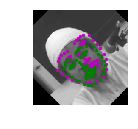

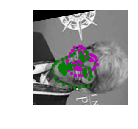

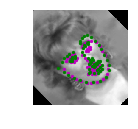

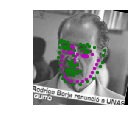

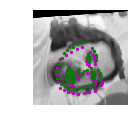

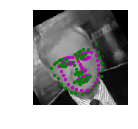

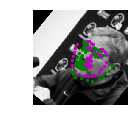

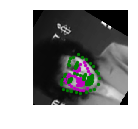

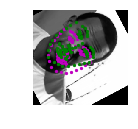

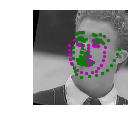

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I have chosen the MSE loss because it's a kind of standard for regression task, like crossentropy for classification. I decided to use Adam optimizer because it includes adaptative learning rates in addition to an exponential momentum that behaves like a momentum.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: Firstly, I took a look at the proposed paper. However, I decided to write a 3 Conv network with three pooling layers and dropout and two fully connected layers. I choose a small architecture in order to avoid overfitting( in addition to two dropouts) but trying to get a good result.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I usually use batches of 32,64 or 128 samples per batch. We are dealing with a relatively small dataset. Then, 32 or 64 samples per batch are ok. The number of epochs is decided to try to detect when loss no longer decrease.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.25466445 -0.34853655 -0.01215536]
 [-0.05484141 -0.10486114  0.3970452 ]
 [ 0.48684806  0.04987357 -0.17135505]]
(3, 3)


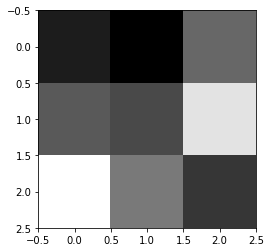

In [23]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data.cpu() if train_on_gpu else net.conv1.weight.data
w = weights1.numpy()

filter_index = 12

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

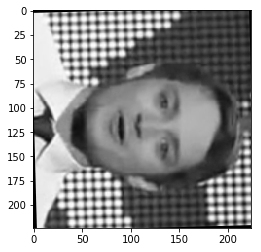

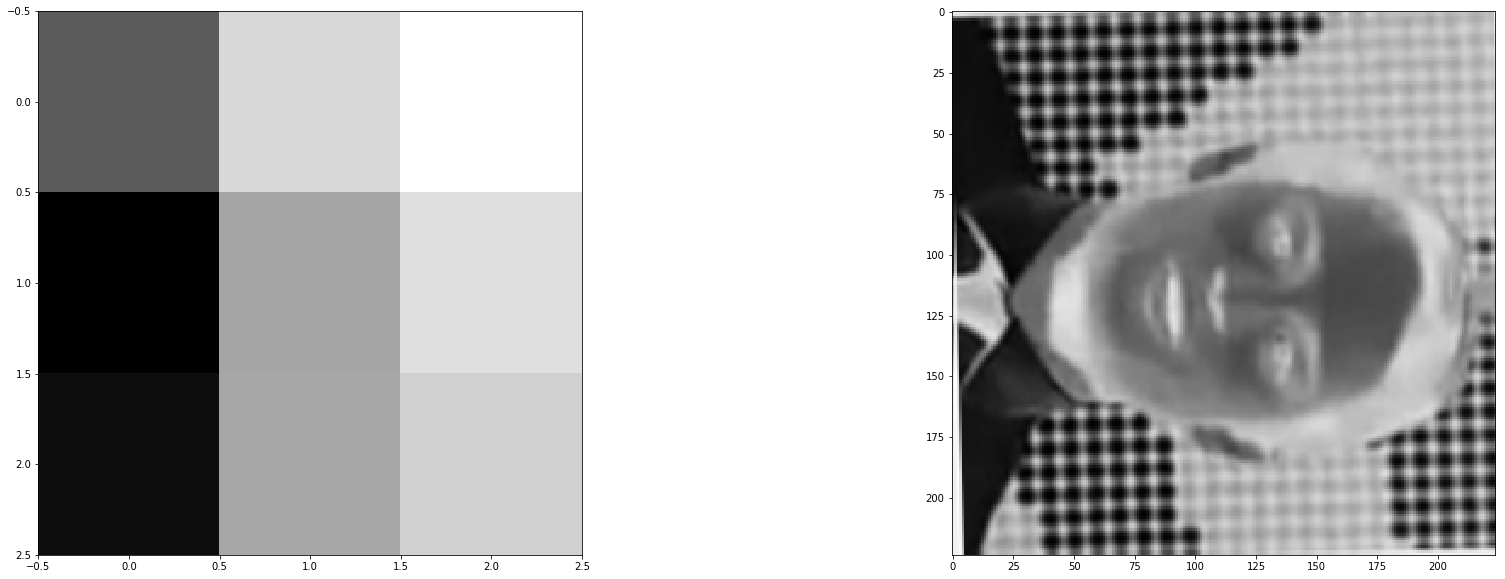

In [55]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
dataiter = iter(test_loader)
sample = dataiter.next()
images = sample["image"].numpy()

# select an image by index
idx = 3
sample = np.squeeze(images[idx])
plt.imshow(sample, cmap='gray')

fig=plt.figure(figsize=(30, 10))
columns = 2
rows = 1
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(sample, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It seems that detect right top corners.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!